
# CMP 414 - Artificial Intelligence Final Project
# Classification on the Telco-Churn Dataset

The dataset and its description is available at Kaggle (https://www.kaggle.com/blastchar/telco-customer-churn). 
The goal of this task is to analyze the behavior of telecom customers and understand what factors are important to retain customers.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import plot_tree
import seaborn as sns

## Install Kaggle API & Download the dataset

In [2]:
# 1. Install the kaggle API
! pip install kaggle

In [3]:
# 2. Upload the kaggle.json file
from google.colab import files

files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"agyapongelija","key":"4d4d572c90e254f2de643b2bbb390cdd"}'}

In [4]:
# 3. Make a directory named kaggle and copy kaggle.json file there
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

# 4. Change the permission of the file
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [6]:
# 5. Download and unzip the dataset
!kaggle datasets download -d blastchar/telco-customer-churn
!unzip telco-customer-churn.zip

telco-customer-churn.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  telco-customer-churn.zip
replace WA_Fn-UseC_-Telco-Customer-Churn.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: WA_Fn-UseC_-Telco-Customer-Churn.csv  


## 0. Load the data



In [7]:
# Load the dataset
telco_data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
telco_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [8]:
# Size of the dataset
print("Shape of Telco dataset:", telco_data.shape)

Shape of Telco dataset: (7043, 21)


In [9]:
# Data types of the columns
telco_data.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [10]:
# Check if there are any missing values
telco_data.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [11]:
#  check the statistics
telco_data.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


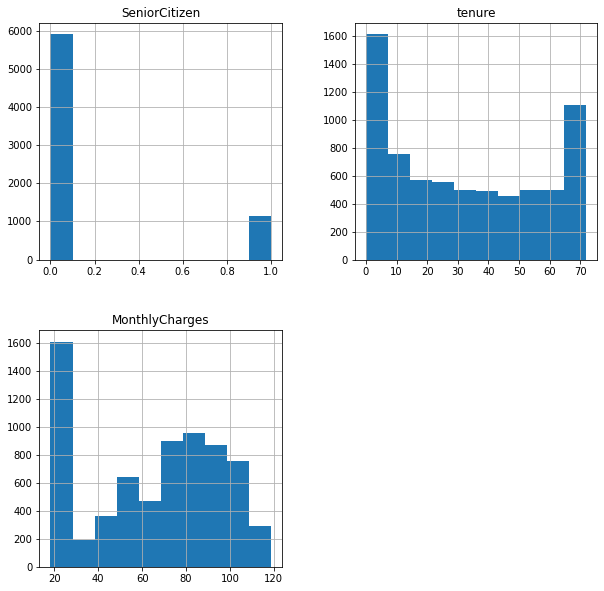

In [12]:
# Display the histograms of the numerical variables
fig = telco_data.hist(figsize=(10, 10))

### **1. Visualize the univariate distribution of each input variable and the target variable “churn”.**

Text(0.5, 1.0, 'PaymentMethod')

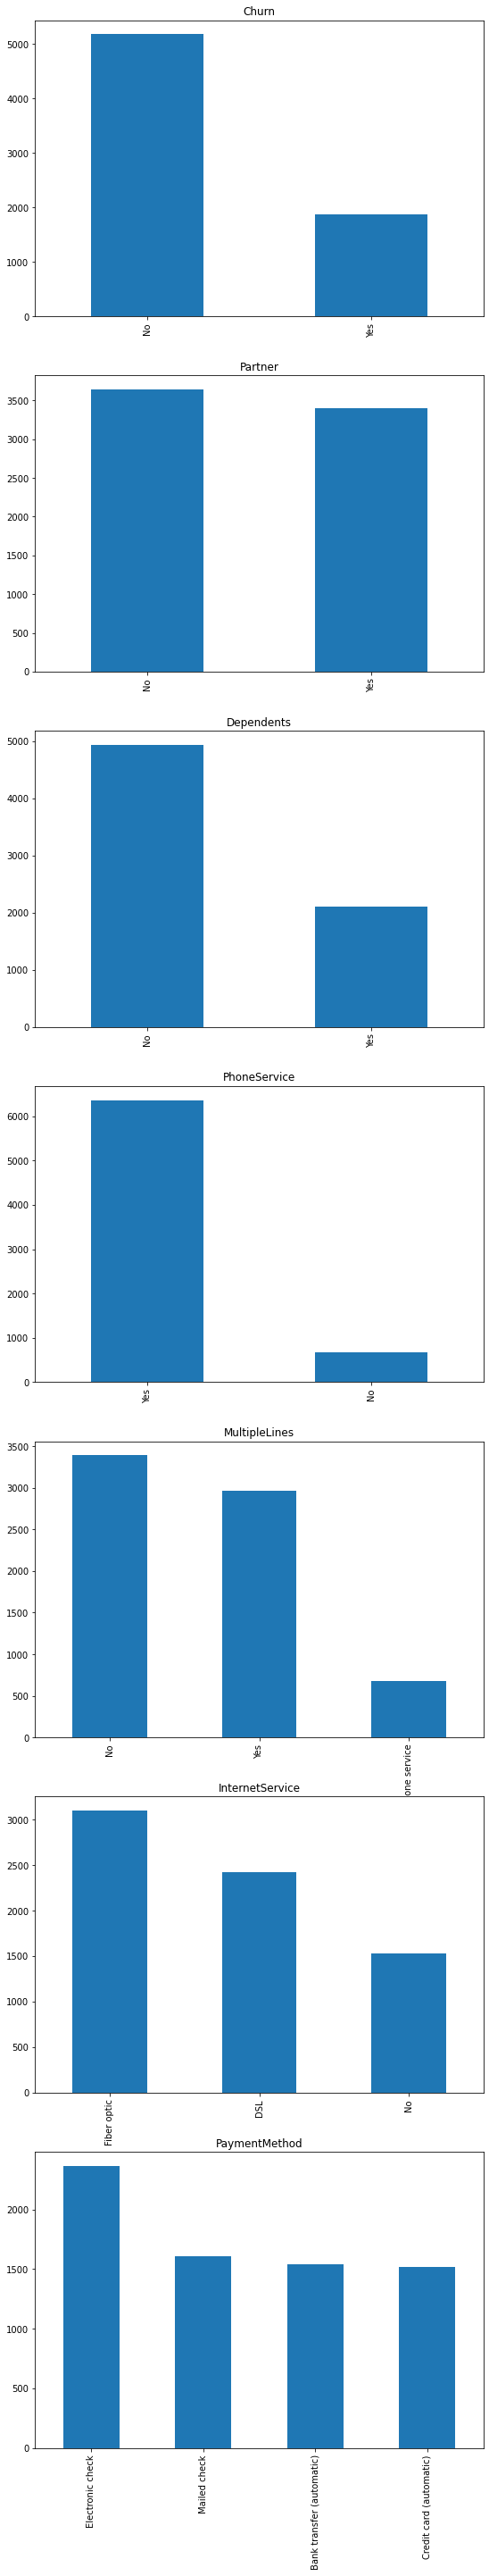

In [13]:
# Display the bar charts of 7 categorical variables
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) =  plt.subplots(7, 1, sharex=False, sharey= False, figsize=(9,50)) 

telco_data['Churn'].value_counts().plot.bar(ax=ax1)
ax1.set_title('Churn')
telco_data['Partner'].value_counts().plot.bar(ax=ax2)
ax2.set_title('Partner')
telco_data['Dependents'].value_counts().plot.bar(ax=ax3)
ax3.set_title('Dependents') 
telco_data['PhoneService'].value_counts().plot.bar(ax=ax4)
ax4.set_title('PhoneService')
telco_data['MultipleLines'].value_counts().plot.bar(ax=ax5)
ax5.set_title('MultipleLines') 
telco_data['InternetService'].value_counts().plot.bar(ax=ax6)
ax6.set_title('InternetService')
telco_data['PaymentMethod'].value_counts().plot.bar(ax=ax7)
ax7.set_title('PaymentMethod')

Text(0.5, 6.79999999999999, 'Churn')

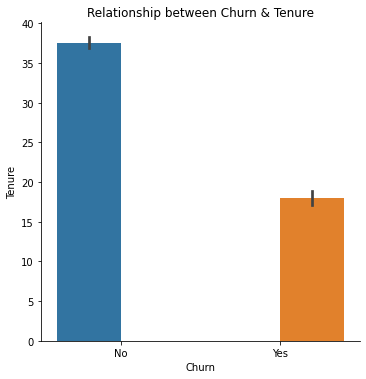

In [41]:
# Plot the graph
sns.catplot(x ="Churn", y ="tenure", kind ="bar", hue ="Churn", data=telco_data)

# Title and axes labels added to the graph
plt.title("Relationship between Churn & Tenure")
plt.ylabel("Tenure")
plt.xlabel("Churn")

Text(0.5, 6.79999999999999, 'Churn')

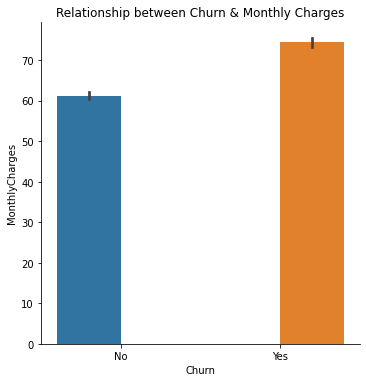

In [45]:
# Plot the graph
sns.catplot(x ="Churn", y ="MonthlyCharges", kind ="bar", hue ="Churn", data=telco_data)

# Title and axes labels added to the graph
plt.title("Relationship between Churn & Monthly Charges")
plt.ylabel("MonthlyCharges")
plt.xlabel("Churn")







### **2.   Split data into training and test sets. Convert each categorical variable into numerical variables using one-hot-encoding.**

In [46]:
# Convert each categorical variable into numerical variables using one-hot-encoding
telco_data = pd.get_dummies(telco_data, columns = ["gender", "Partner", "Dependents", "PaymentMethod", "PhoneService", "MultipleLines" \
                                             ,"InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport" \
                                             ,"StreamingTV", "StreamingMovies", "Contract", "PaperlessBilling", "PaymentMethod" \
                                             ,"Churn"], drop_first = True)

In [47]:
# Drop the "customerID" column, as the model tries to find the general relationship between churn and other factors.
telco_data.drop(columns="customerID", axis=1, inplace=True)

In [48]:
telco_data.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes
0,0,1,29.85,29.85,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
1,0,34,56.95,1889.5,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
2,0,2,53.85,108.15,1,0,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1
3,0,45,42.30,1840.75,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0
4,0,2,70.70,151.65,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1


In [49]:
# Convert the data types from string to int because the model cannot fit a string data type
telco_data = telco_data[["gender_Male", "Partner_Yes", "Dependents_Yes", "PaymentMethod_Credit card (automatic)" \
                        , "PaymentMethod_Electronic check", "PaymentMethod_Mailed check", "PhoneService_Yes" \
                        , "MultipleLines_No phone service", "MultipleLines_Yes", "InternetService_Fiber optic"\
                        , "InternetService_No", "OnlineSecurity_No internet service", "OnlineSecurity_Yes" \
                        , "OnlineBackup_No internet service", "OnlineBackup_Yes", "DeviceProtection_No internet service" \
                        , "DeviceProtection_Yes", "TechSupport_No internet service", "StreamingTV_No internet service"\
                        , "StreamingTV_Yes", "StreamingMovies_No internet service", "StreamingMovies_Yes" \
                        , "Contract_One year", "Contract_Two year", "PaperlessBilling_Yes" \
                        , "PaymentMethod_Credit card (automatic)", "PaymentMethod_Electronic check" \
                        , "PaymentMethod_Mailed check", "Churn_Yes"]].astype(int)

In [50]:
# Create a new dataframe x which contains all the input (independent) variables 
x = telco_data.drop(columns="Churn_Yes")

# Create a new dataframe y which contains all the target (dependent) variable -> Churn
y = telco_data["Churn_Yes"]

In [51]:
# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [52]:
print("Shape of x train:", x_train.shape)
print("Shape of x test:", x_test.shape)

Shape of x train: (5634, 34)
Shape of x test: (1409, 34)


### **3. Evaluate the following classification models:**
*   Logistic Regression 
*   Support Vector Machine
*   K Nearest Neighbors
*   Decision Trees
*   Random Forests

### A. Logistic Regression

In [53]:
# Initialize the logistic regression model
logit_model = LogisticRegression()

# Fit the model to the training data
logit_model.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [54]:
# Use the model to make predictions on the test data
y_test_preds_logit = logit_model.predict(x_test)

In [55]:
# Calculate the accuracy score of the model 
accuracy1 = accuracy_score(y_test, y_test_preds_logit)
print("Accuracy score is: ", accuracy1)

Accuracy score is:  0.7764371894960965


In [56]:
# Calculate the precision score of the model 
precision1 = precision_score(y_test, y_test_preds_logit)
print("Precision score is: ", precision1)

Precision score is:  0.564179104477612


In [57]:
# Calculate the recall score of the model 
recall1 = recall_score(y_test, y_test_preds_logit)
print("Recall score is: ", recall1)

Recall score is:  0.5279329608938548


In [58]:
# Calculate the f-1 score of the model 
f1_1 = f1_score(y_test, y_test_preds_logit)
print("f1 score is: ", f1_1)

f1 score is:  0.5454545454545455


### B. Support Vector Machine

In [59]:
# Initialize the SVM model
svm_model = LinearSVC()

# Fit the model to the training data
svm_model.fit(x_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [60]:
# Use the model to make predictions on the test data
y_test_preds_svm = svm_model.predict(x_test)

In [61]:
# Calculate the accuracy score of the model 
accuracy2 = accuracy_score(y_test, y_test_preds_svm)
print("Accuracy score is: ", accuracy2)

Accuracy score is:  0.7821149751596878


In [62]:
# Calculate the precision score of the model 
precision2 = precision_score(y_test, y_test_preds_svm)
print("Precision score is: ", precision2)

Precision score is:  0.580441640378549


In [63]:
# Calculate the recall score of the model 
recall2 = recall_score(y_test, y_test_preds_svm)
print("Recall score is: ", recall2)

Recall score is:  0.5139664804469274


In [64]:
# Calculate the f-1 score of the model 
f1_2 = f1_score(y_test, y_test_preds_svm)
print("f1 score is: ", f1_2)

f1 score is:  0.5451851851851852


### C. K Nearest Neighbors

In [65]:
# Initialize the KNN model
knn3_model = KNeighborsClassifier(n_neighbors=3)

# Fit the model to the training data
knn3_model.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [66]:
# Use the model to make predictions on the test data
y_test_preds_knn3 = knn3_model.predict(x_test)

In [67]:
# Calculate the accuracy score of the model 
accuracy3 = accuracy_score(y_test, y_test_preds_knn3)
print("Accuracy score is: ", accuracy3)

Accuracy score is:  0.7246273953158269


In [68]:
# Calculate the precision score of the model 
precision3 = precision_score(y_test, y_test_preds_knn3)
print("Precision score is: ", precision3)

Precision score is:  0.4626865671641791


In [69]:
# Calculate the recall score of the model 
recall3 = recall_score(y_test, y_test_preds_knn3)
print("Recall score is: ", recall3)

Recall score is:  0.5195530726256983


In [70]:
# Calculate the f-1 score of the model 
f1_3 = f1_score(y_test, y_test_preds_knn3)
print("f1 score is: ", f1_3)

f1 score is:  0.48947368421052634


### D. Decision Tree 

In [71]:
# Initialize the Decision Tree model
tree3_model = DecisionTreeClassifier(max_depth=3)

# Fit the model to the training data
tree3_model.fit(x_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [72]:
# Use the model to make predictions on the test data
y_test_preds_tree3 = tree3_model.predict(x_test)

In [73]:
# Calculate the accuracy score of the model 
accuracy4 = accuracy_score(y_test, y_test_preds_tree3)
print("Accuracy score is: ", accuracy4)

Accuracy score is:  0.7608232789212207


In [74]:
# Calculate the precision score of the model 
precision4 = precision_score(y_test, y_test_preds_tree3)
print("Precision score is: ", precision4)

Precision score is:  0.5232815964523282


In [75]:
# Calculate the recall score of the model 
recall4 = recall_score(y_test, y_test_preds_tree3)
print("Recall score is: ", recall4)

Recall score is:  0.659217877094972


In [76]:
# Calculate the f-1 score of the model 
f1_4 = f1_score(y_test, y_test_preds_tree3)
print("f1 score is: ", f1_4)

f1 score is:  0.5834363411619283


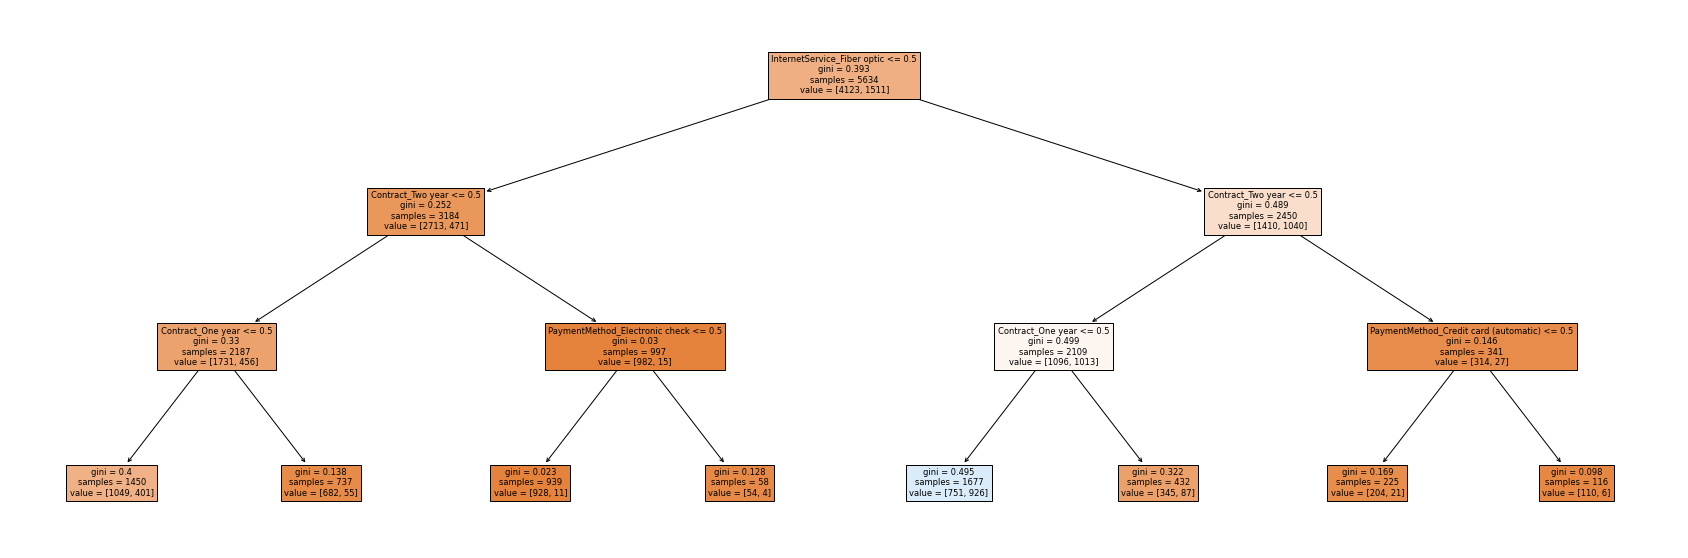

In [77]:
# Visualize the decision tree
plt.figure(figsize=(30,10))
plot_tree(tree3_model, feature_names=x_test.columns, filled=True)
plt.show()

### E. Random Forest 

In [78]:
# Initialize the Random Forest model
rf3_model = RandomForestClassifier(n_estimators=500, max_depth=3)

# Fit the model to the training data
rf3_model.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [79]:
# Use the model to make predictions on the test data
y_test_preds_rf = rf3_model.predict(x_test)

In [80]:
# Calculate the accuracy score of the model 
accuracy5 = accuracy_score(y_test, y_test_preds_rf)
print("Accuracy score is: ", accuracy5)

Accuracy score is:  0.7842441447835344


In [81]:
# Calculate the precision score of the model 
precision5 = precision_score(y_test, y_test_preds_rf)
print("Precision score is: ", precision5)

Precision score is:  0.6285714285714286


In [82]:
# Calculate the recall score of the model 
recall5 = recall_score(y_test, y_test_preds_rf)
print("Recall score is: ", recall5)

Recall score is:  0.3687150837988827


In [83]:
# Calculate the f-1 score of the model 
f1_5 = f1_score(y_test, y_test_preds_rf)
print("f1 score is: ", f1_5)

f1 score is:  0.4647887323943662


### **4. The best model after analyzing the accuracy, precision, recall, and F-1 score is:**

The **Decision Tree Model** because it has a higher accuracy score and both the precision score and the recall score is higher relatively compared to other models.

### **5. Which types of customers are less likely to end the service?**
Customers that have fiber optic internet service who have a two year contract agreement are less likely to end the service because fiber optic provides a higher internet speed than a DSL